In [1]:
###Import required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys
sys.path.insert(1, '../analysis')
from models import fa_layerednegativemetabolicloop, fa_negativegeneloop, fa_negativemetabolicloop, fa_openloop
import numpy as np
from scikits.odes.ode import ode

In [2]:
###Specify if figures are to be saved to PNG
save_figs = True

###Color palette
orders = ['Open Loop', 'Open Loop Intermediate', 'Negative Gene Loop', 'Negative Metabolic Loop', 'Layered Negative Metabolic Loop']
palette = {'Open Loop': sns.color_palette()[3], 'Open Loop Intermediate': 'tab:purple', 'Negative Metabolic Loop': 'tab:green', 'Negative Gene Loop': 'tab:orange', 'Layered Negative Metabolic Loop': 'tab:blue', 'Initial':'black'}

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/matplotlib/transforms.py:740: UserWarning: Warning: converting a masked element to nan.
  points = np.asarray(points, float)
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


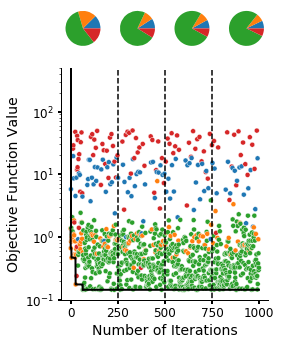

In [3]:
###FIGURE: Sample results
landscape = pd.read_csv('../data/fatty_acid_sample_run_production_burden.csv')
fig = plt.figure(figsize=(4, 5))
gs = gridspec.GridSpec(nrows=2, ncols=4, height_ratios=[1, 4], width_ratios=[1, 1, 1, 1])

ax = fig.add_subplot(gs[1, :])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_ylabel('Objective Function Value', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-2, 5E2])
sns.scatterplot(x='index', y='loss', hue='circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False, s=25)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')

prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape.best_loss_circuit[i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color='k', linewidth=2)
ax.vlines(0, landscape.best_losses[starts], 10E9, color='k', linewidth=2)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
ax.tick_params(width=2)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)
ax.spines['bottom'].set_linewidth(1)
ax.spines['left'].set_linewidth(1)

quarter1 = (landscape.iloc[0:250].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='circuit').groupby('circuit').count().loss/250).reset_index()
colors = ['tab:blue', 'tab:orange', 'tab:green', sns.color_palette()[3], 'tab:purple']

ax = fig.add_subplot(gs[0, 0])
ax.pie(quarter1.loss, colors=colors)

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter2.loss, colors=colors)

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter3.loss, colors=colors)

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter4.loss, colors=colors)

fig.tight_layout()
if save_figs: fig.savefig('../figs/fatty_acid_sample_run.png', dpi=300)


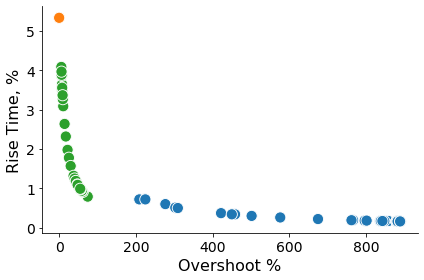

In [19]:
###FIGURE: Pareto curve
optimal = pd.read_csv('../data/fatty_acid_pareto_curve_speed_accuracy.csv')
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot()
ax.set_xlabel('Overshoot %', fontsize=16)
ax.set_ylabel('Rise Time, %', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)

sns.scatterplot(data=optimal, x='overshoot', y='rise_time', hue='circuit', palette=palette, s=125, legend=False, ax=ax)
fig.tight_layout()
if save_figs: fig.savefig('../figs/fatty_acid_pareto_curve.png', dpi=500)

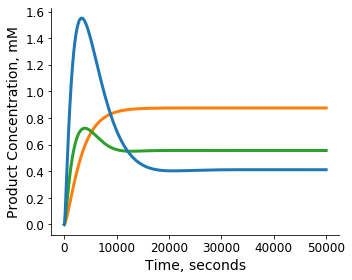

In [4]:
def objective(args):
    architecture, param_values = args
    #Integration conditions
    sampling_rate = 10000
    t = np.linspace(0, 5E4, sampling_rate)

    #Select architecture and generate function
    if architecture == 'Open Loop':
        ode_function = fa_openloop
        y0 = np.array([0., 0., 0., 0.])
    elif architecture == 'Negative Gene Loop':
        ode_function = fa_negativegeneloop
        y0 = np.array([0., 0., 0., 0., 0.])
    elif architecture == 'Negative Metabolic Loop':
        ode_function = fa_negativemetabolicloop
        y0 = np.array([0., 0., 0., 0.])
    else:
        ode_function = fa_layerednegativemetabolicloop
        y0 = np.array([0., 0., 0., 0., 0.])
    
    extra_options = {'old_api': False, 'user_data': param_values}
    ode_solver = ode('cvode', ode_function, **extra_options)
    solution = ode_solver.solve(t, y0)
    
    return solution


fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot()
ax.set_xlabel('Time, seconds', fontsize=14)
ax.set_ylabel('Product Concentration, mM', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.tick_params(axis='x', labelsize=12)

for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0)


for i in range(len(optimal)):
    op = optimal.iloc[i]
    if op.circuit == 'Negative Gene Loop' and i == 146:
        sol = objective([op.circuit, [op.r_tl_ngl, op.r_tl_tetR_ngl]])
        plt.plot(sol.values.t, sol.values.y[:, 0], color=palette[op.circuit], lw=3)
    if op.circuit == 'Negative Metabolic Loop' and i == 223:
        sol = objective([op.circuit, [op.r_fl_prime_nml, op.ki_nml]])
        plt.plot(sol.values.t, sol.values.y[:, 0], color=palette[op.circuit], lw=3)
    if op.circuit == 'Layered Negative Metabolic Loop' and i == 233:
        sol = objective([op.circuit, [op.r_tl_lnml, op.r_ar2_lnml]])
        plt.plot(sol.values.t, sol.values.y[:, 0], color=palette[op.circuit], lw=3)

# opt_b = optimal.loc[optimal.circuit=='Negative Gene Loop'].loc[optimal.loss == optimal.loss.min()].reset_index(drop=True)
# sol = objective(["Negative Gene Loop", [opt_b.r_tl_ngl[0], opt_b.r_tl_tetR_ngl[0]]]) #B
# plt.plot(sol.values.t, sol.values.y[:, 0], color=palette['Negative Gene Loop'], lw=3)

# opt_c = optimal.loc[optimal.circuit=='Negative Metabolic Loop']
# opt_c = opt_c.loc[opt_c.loss == opt_c.loss.min()].reset_index(drop=True)
# sol = objective(["Negative Metabolic Loop", [opt_c.r_fl_prime_nml[0], opt_c.ki_nml[0]]]) #C
# plt.plot(sol.values.t, sol.values.y[:, 0], color=palette['Negative Metabolic Loop'], lw=3)

# opt_d = optimal.loc[optimal.circuit=='Layered Negative Metabolic Loop']
# opt_d = opt_d.loc[opt_d.loss == opt_d.loss.min()].reset_index(drop=True)
# sol = objective(["Negative Metabolic Loop", [opt_d.r_tl_lnml[0], opt_d.r_ar2_lnml[0]]]) #D
# plt.plot(sol.values.t, sol.values.y[:, 0], color=palette['Layered Negative Metabolic Loop'], lw=3)
fig.tight_layout()

# print(opt_c.alpha[0])
# print(opt_d.alpha[0])
# print(opt_b.alpha[0])
if save_figs: fig.savefig('../figs/fa_trajectories.png', dpi=500)
